In [1]:
import kaggle

kaggle.api.dataset_download_files('manjilkarki/deepfake-and-real-images', path='/datasets/', unzip=True)


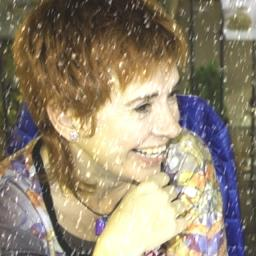

In [3]:
from IPython.display import Image
Image(filename='/datasets/Dataset/Test/Real/real_2.jpg', width=500) 

## Imports Packages

In [17]:
# imports

# python standard libraries
import os
import random
import fnmatch
import datetime
import pickle
import json

# data processing
import numpy as np
np.set_printoptions(formatter={'float_kind':lambda x: "%.4f" % x})

import pandas as pd
pd.set_option('display.width', 300)
pd.set_option('display.float_format', '{:,.4f}'.format)
pd.set_option('display.max_colwidth', 200)

# tensorflow
import tensorflow as tf
import keras
from keras.models import Sequential  # V2 is tensorflow.keras.xxxx, V1 is keras.xxx
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from keras.optimizers import Adam
from keras.models import load_model

print( f'tf.__version__: {tf.__version__}' )
print( f'keras.__version__: {keras.__version__}' )

# sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# imaging
import cv2
from imgaug import augmenters as img_aug
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image


tf.__version__: 2.15.0
keras.__version__: 2.15.0


## Load Train Data

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] ['/datasets/Dataset/Test/Fake/fake_1076.jpg', '/datasets/Dataset/Test/Fake/fake_1077.jpg', '/datasets/Dataset/Test/Fake/fake_1078.jpg', '/datasets/Dataset/Test/Fake/fake_1079.jpg', '/datasets/Dataset/Test/Fake/fake_108.jpg', '/datasets/Dataset/Test/Fake/fake_1080.jpg', '/datasets/Dataset/Test/Fake/fake_1081.jpg', '/datasets/Dataset/Test/Fake/fake_1082.jpg', '/datasets/Dataset/Test/Fake/fake_1083.jpg', '/datasets/Dataset/Test/Fake/fake_1084.jpg', '/datasets/Dataset/Test/Fake/fake_1085.jpg', '/datasets/Dataset/Test/Fake/fake_1086.jpg', '/datasets/Dataset/Test/Fake/fake_1087.jpg', '/datasets/Dataset/Test/Fake/fake_1088.jpg', '/datasets/Dataset/Test/Fake/fake_1089.jpg', '/datasets/Dataset/Test/Fake/fake_109.jpg', '/datasets/Dataset/Test/Fake/fake_1090.jpg', '/datasets/Dataset/Test/Fake/fake_1091.jpg', '/datasets/Dataset/Test/Fake/fake_1092.jpg', '/datasets/Dataset/Test/Fake/fake_1093.jpg']
image_path: /datasets/Dataset/Test/Fake/

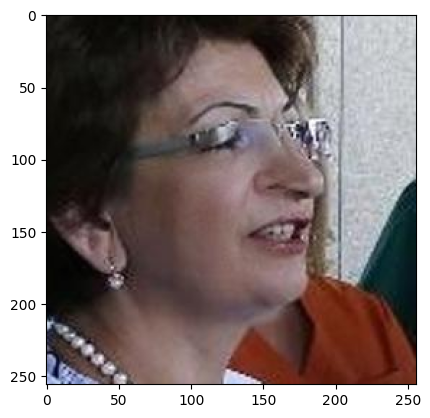

In [18]:
# import data
image_paths = []
commands = []
train_dir = '/datasets/Dataset/Train/'
test_dir = '/datasets/Dataset/Test/'
validation_dir = '/datasets/Dataset/Validation/'
model_output_dir = '.'

for image in os.listdir(os.path.join(test_dir, 'Real/')):
    image_paths.append(os.path.join(test_dir, 'Real/', image))
    commands.append(1)

for image in os.listdir(os.path.join(test_dir, 'Fake/')):
    image_paths.append(os.path.join(test_dir, 'Fake/', image))
    commands.append(0)

print(commands[5500:5520], image_paths[5500:5520])    


image_index = 5500
plt.imshow(Image.open(image_paths[image_index]))
print("image_path: %s" % image_paths[image_index] )
print("command: %d" % commands[image_index] )
df = pd.DataFrame()
df['image_path'] = image_paths
df['command'] = commands

(array([5492.0000, 5413.0000]),
 array([0.0000, 0.5000, 1.0000]),
 <BarContainer object of 2 artists>)

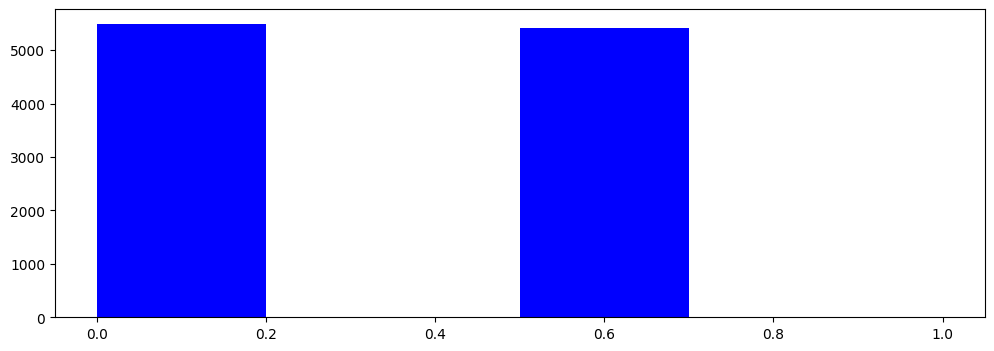

In [19]:
# Look at the distribution of commands
# distribution has to be balanced
num_of_bins = 2

hist, bins = np.histogram(df['command'], num_of_bins)

fig, axes = plt.subplots(1,1, figsize=(12,4))
axes.hist(df['command'], bins=num_of_bins, width=0.2, color='blue')

In [20]:
X_train, X_valid, y_train, y_valid = train_test_split( image_paths, commands, test_size=0.2)
print("Training data: %d\nValidation data: %d" % (len(X_train), len(X_valid)))


Training data: 8724
Validation data: 2181


In [21]:
def my_imread(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    scale_percent = 80 # percent of original size
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    dim = (width, height)
    # resize image
    resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
    return resized

## Preprocess Training Data for Nvidia Model

Text(0.5, 1.0, 'processed')

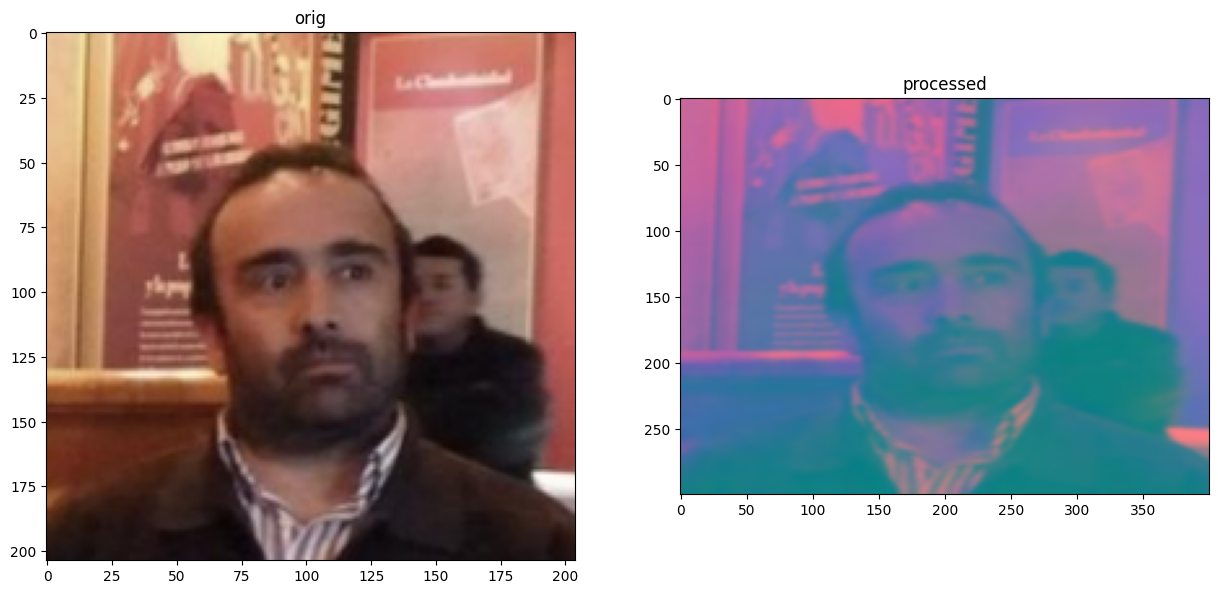

In [22]:
image_index = 17
def img_preprocess(image):
    height, _, _ = image.shape
    image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)  # Nvidia model said it is best to use YUV color space
    image = cv2.GaussianBlur(image, (3,3), 0)
    image = cv2.resize(image, (400,300)) # input image size (200,66) Nvidia model
    image = image / 255 # normalizing, the processed image becomes black for some reason.  do we need this?
    return image

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(image_paths[image_index])
image_processed = img_preprocess(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_processed)
axes[1].set_title("processed")


## Create and Train Model

In [23]:
def nvidia_model():
    model = Sequential(name='Nvidia_Model')
    
    # elu=Expenential Linear Unit, similar to leaky Relu
    # skipping 1st hiddel layer (nomralization layer), as we have normalized the data
    
    # Convolution Layers
    model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=(300, 400, 3), activation='elu')) 
    model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu')) 
    model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu')) 
    model.add(Conv2D(64, (3, 3), activation='elu')) 
    model.add(Dropout(0.2)) # not in original model. added for more robustness
    model.add(Conv2D(64, (3, 3), activation='elu')) 
    
    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dropout(0.2)) # not in original model. added for more robustness
    model.add(Dense(100, activation='elu'))
    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation='elu'))
    
    # output layer: turn angle (from 45-135, 90 is straight, <90 turn left, >90 turn right)
    model.add(Dense(1)) 
    
    # since this is a regression problem not classification problem,
    # we use MSE (Mean Squared Error) as loss function
    optimizer = Adam(learning_rate=1e-3) # lr is learning rate
    model.compile(loss='mse', optimizer=optimizer)
    
    return model

In [24]:
model = nvidia_model()
print(model.summary())
# check at we will have 252,219 trainable parameters

Model: "Nvidia_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 148, 198, 24)      1824      
                                                                 
 conv2d_6 (Conv2D)           (None, 72, 97, 36)        21636     
                                                                 
 conv2d_7 (Conv2D)           (None, 34, 47, 48)        43248     
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 45, 64)        27712     
                                                                 
 dropout_2 (Dropout)         (None, 32, 45, 64)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 30, 43, 64)        36928     
                                                                 
 flatten_1 (Flatten)         (None, 82560)            

In [25]:
def image_data_generator(image_paths, commands, batch_size, is_training):
    while True:
        batch_images = []
        batch_commands = []
        
        for i in range(batch_size):
            random_index = random.randint(0, len(image_paths) - 1)
            image_path = image_paths[random_index]
            image = my_imread(image_paths[random_index])
            command = commands[random_index]
            image = img_preprocess(image)
            batch_images.append(image)
            batch_commands.append(command)
            
        yield( np.asarray(batch_images), np.asarray(batch_commands))
            
            

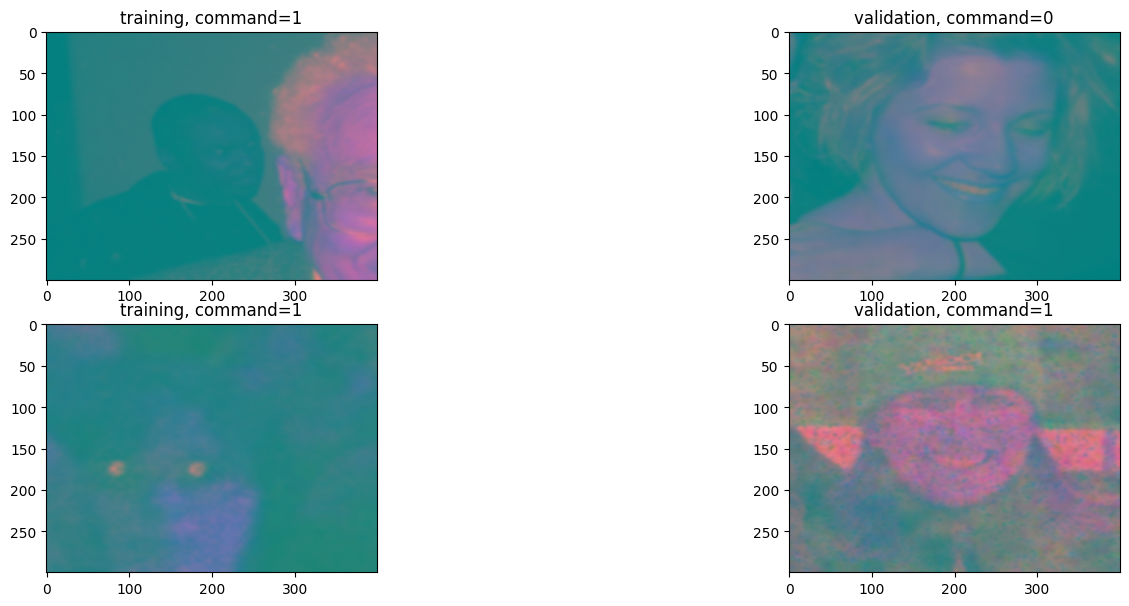

In [26]:
ncol = 2
nrow = 2

X_train_batch, y_train_batch = next(image_data_generator(X_train, y_train, nrow, True))
X_valid_batch, y_valid_batch = next(image_data_generator(X_valid, y_valid, nrow, False))

fig, axes = plt.subplots(nrow, ncol, figsize=(15, 6))
fig.tight_layout()

for i in range(nrow):
    axes[i][0].imshow(X_train_batch[i])
    axes[i][0].set_title("training, command=%s" % y_train_batch[i])
    axes[i][1].imshow(X_valid_batch[i])
    axes[i][1].set_title("validation, command=%s" % y_valid_batch[i])


In [27]:
# start Tensorboard before model fit, so we can see the epoch tick in Tensorboard
# Jupyter Notebook embedded Tensorboard is a new feature in TF 2.0!!  

# clean up log folder for tensorboard
log_dir_root = f'{model_output_dir}/logs/'
#!rm -rf $log_dir_root


In [12]:
# saves the model weights after each epoch if the validation loss decreased
checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=os.path.join(model_output_dir,'deepfake_classifier.h5'), verbose=1, save_best_only=True)

print("deepfake classifier train started")
history = model.fit(image_data_generator( X_train, y_train, batch_size=200, is_training=True),
                              steps_per_epoch=600,
                              epochs=10,
                              validation_data = image_data_generator( X_valid, y_valid, batch_size=200, is_training=False),
                              validation_steps=400,
                              verbose=1,
                              shuffle=1,
                              callbacks=[checkpoint_callback])
# always save model output as soon as model finishes training
model.save(os.path.join(model_output_dir,'deepfake_classifier.h5'))

date_str = datetime.datetime.now().strftime("%y%m%d_%H%M%S")
history_path = os.path.join(model_output_dir,'history.pickle')
with open(history_path, 'wb') as f:
    pickle.dump(history.history, f, pickle.HIGHEST_PROTOCOL)
    
print("deepfake classifier train finished. val_loss from %.1f to %.1f" % (history.history['val_loss'][0], history.history['val_loss'][-1]))


deepfake classifier train started
Epoch 1/10
600/600 [==============================] - ETA: 0s - loss: 12.8603
Epoch 1: val_loss improved from inf to 0.20260, saving model to ./deepfake_classifier.h5
600/600 [==============================] - 3221s 5s/step - loss: 12.8603 - val_loss: 0.2026
Epoch 2/10


/my-jupyter-env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


600/600 [==============================] - ETA: 0s - loss: 0.1948
Epoch 2: val_loss improved from 0.20260 to 0.19348, saving model to ./deepfake_classifier.h5
600/600 [==============================] - 3228s 5s/step - loss: 0.1948 - val_loss: 0.1935
Epoch 3/10
600/600 [==============================] - ETA: 0s - loss: 0.1786
Epoch 3: val_loss did not improve from 0.19348
600/600 [==============================] - 3319s 6s/step - loss: 0.1786 - val_loss: 0.1989
Epoch 4/10
600/600 [==============================] - ETA: 0s - loss: 0.1586
Epoch 4: val_loss did not improve from 0.19348
600/600 [==============================] - 3249s 5s/step - loss: 0.1586 - val_loss: 0.1968
Epoch 5/10
600/600 [==============================] - ETA: 0s - loss: 0.1214
Epoch 5: val_loss did not improve from 0.19348
600/600 [==============================] - 3226s 5s/step - loss: 0.1214 - val_loss: 0.2162
Epoch 6/10
600/600 [==============================] - ETA: 0s - loss: 0.0747
Epoch 6: val_loss did not im

## Check Trained Model on Validation Data

In [28]:
# plot training and validation losses
# this should be the same as tensorboard
history_path = os.path.join(model_output_dir,'history.pickle')
with open(history_path, 'rb') as f:
    history = pickle.load(f)

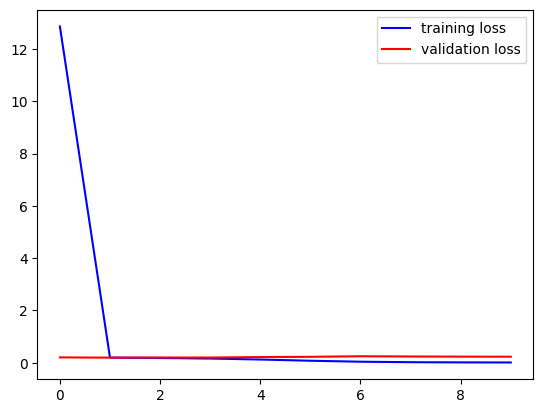

In [29]:
history
plt.plot(history['loss'],color='blue')
plt.plot(history['val_loss'],color='red')
plt.legend(["training loss", "validation loss"])

In [33]:
from sklearn.metrics import mean_squared_error, r2_score

def summarize_prediction(Y_true, Y_pred):
    
    mse = mean_squared_error(Y_true, Y_pred)
    r_squared = r2_score(Y_true, Y_pred)
    
    print(f'mse       = {mse:.2}')
    print(f'r_squared = {r_squared:.2%}')
    print()
    
def predict_and_summarize(X, Y):
    model = load_model(f'{model_output_dir}/deepfake_classifier.h5')
    Y_pred2 = []
    Y_pred = model.predict(X)
    for y in Y_pred:
        Y_pred2.append(y)
    summarize_prediction(Y, Y_pred2)
    # for y in zip(Y, Y_pred):
    #     print(y)
    return Y_pred

In [31]:
len(X_train)

8724

In [36]:
n_tests = 1000
X_test, y_test = next(image_data_generator(X_valid, y_valid, n_tests, False))

y_pred = predict_and_summarize(X_test, y_test)

# n_tests_show = 2
# fig, axes = plt.subplots(n_tests_show, 1, figsize=(10, 4 * n_tests_show))
# for i in range(n_tests_show):
#     axes[i].imshow(X_test[i])
#     axes[i].set_title(f"actual command={y_test[i]}, predicted command={int(y_pred[i])}, diff = {int(y_pred[i])-y_test[i]}")


32/32 [==============================] - 3s 81ms/step
mse       = 0.049
r_squared = 80.43%



In [35]:
def imread(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    scale_percent = 5 # percent of original size
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    dim = (width, height)
    # resize image
    resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
    return resized

model = load_model(f'{model_output_dir}/deepfake_classifier.h5')
X = np.array([
    img_preprocess(imread(f'{test_dir}/Fake/fake_5000.jpg')),
    img_preprocess(imread(f'{test_dir}/Real/real_1000.jpg')),
    img_preprocess(imread(f'{test_dir}/Real/real_4024.jpg')),
    img_preprocess(imread(f'{test_dir}/Fake/fake_1214.jpg')),
])
print(X_test.shape)
print(np.array([X]).shape)
Y_pred = model.predict([X])
Y_pred.round()

(1000, 300, 400, 3)
(1, 4, 300, 400, 3)
1/1 [==============================] - 0s 127ms/step


array([[0.0000],
       [1.0000],
       [1.0000],
       [0.0000]], dtype=float32)